# Wikidata Ogham Sites Map Visualisation

This notebook fetches Ogham data using a SPARQL query from Wikidata and creates maps.

## Define SPARQL query service

In [6]:
import os
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx  # For adding OpenStreetMap basemaps
from matplotlib.patches import Patch
from scipy.stats import gaussian_kde
import numpy as np

def querySparql(query):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    return results['results']['bindings']

# Define the GeoJSON file path
geojson_file = os.path.join(os.getcwd(), "gs_ireland_island.geojson")  # Adjusted for Jupyter Notebook

## Define the SPARQL Query

In [7]:

# SPARQL Query
oghamQuery = """
SELECT ?item ?itemLabel ?geo ?site ?siteLabel ?county ?countyLabel WHERE { 
  ?item wdt:P31 wd:Q2016147.
  ?item wdt:P189 ?site.
  ?site wdt:P31 wd:Q72617071.
  ?item wdt:P189 ?county.
  ?county wdt:P31 wd:Q179872.
  ?item wdt:P625 ?geo.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""

## Fetch Data and Convert to DataFrame

In [8]:
# Fetch data using the SPARQL query
sparql_results = querySparql(oghamQuery)

# Convert SPARQL JSON results into a DataFrame
data = []
for result in sparql_results:
    geo = result['geo']['value'] if 'geo' in result else None
    lat, lon = (None, None)
    if geo:
        lon, lat = map(float, geo.replace("Point(", "").replace(")", "").split())
    data.append({
        "item": result['item']['value'],
        "itemLabel": result['itemLabel']['value'],
        "site": result['site']['value'],
        "siteLabel": result['siteLabel']['value'],
        "county": result['county']['value'],
        "countyLabel": result['countyLabel']['value'],
        "latitude": lat,
        "longitude": lon,
    })

df = pd.DataFrame(data)
df

,item,itemLabel,site,siteLabel,county,countyLabel,latitude,longitude
0,http://www.wikidata.org/entity/Q70892459,CIIC 71 (Ogham Stone Concept by RAS Macalister),http://www.wikidata.org/entity/Q85394002,Ahalisky (Ogham Site),http://www.wikidata.org/entity/Q162475,County Cork,51.678889,-8.846944
1,http://www.wikidata.org/entity/Q70892460,CIIC 72 (Ogham Stone Concept by RAS Macalister),http://www.wikidata.org/entity/Q85394004,Aultagh (Ogham Site),http://www.wikidata.org/entity/Q162475,County Cork,51.770833,-9.088056
2,http://www.wikidata.org/entity/Q70892463,CIIC 73 (Ogham Stone Concept by RAS Macalister),http://www.wikidata.org/entity/Q85393926,Carhoovauler (Ogham Site),http://www.wikidata.org/entity/Q162475,County Cork,51.688333,-8.956111
3,http://www.wikidata.org/entity/Q70892466,CIIC 74 (Ogham Stone Concept by RAS Macalister),http://www.wikidata.org/entity/Q85393926,Carhoovauler (Ogham Site),http://www.wikidata.org/entity/Q162475,County Cork,51.688333,-8.956111
4,http://www.wikidata.org/entity/Q70892468,CIIC 75 (Ogham Stone Concept by RAS Macalister),http://www.wikidata.org/entity/Q85393928,Keenrath (Ogham Site),http://www.wikidata.org/entity/Q162475,County Cork,51.759444,-9.185833
...,...,...,...,...,...,...,...,...
328,http://www.wikidata.org/entity/Q70892620,CIIC 156 (Ogham Stone Concept by RAS Macalister),http://www.wikidata.org/entity/Q85393964,Ballintaggart (Ogham Site),http://www.wikidata.org/entity/Q184469,County Kerry,52.172500,-10.031111
329,http://www.wikidata.org/entity/Q70892623,CIIC 157 (Ogham Stone Concept by RAS Macalister),http://www.wikidata.org/entity/Q85393964,Ballintaggart (Ogham Site),http://www.wikidata.org/entity/Q184469,County Kerry,52.172500,-10.031111
330,http://www.wikidata.org/entity/Q70892626,CIIC 158 (Ogham Stone Concept by RAS Macalister),http://www.wikidata.org/entity/Q85393964,Ballintaggart (Ogham Site),http://www.wikidata.org/entity/Q184469,County Kerry,52.172500,-10.031111
331,http://www.wikidata.org/entity/Q70892629,CIIC 159 (Ogham Stone Concept by RAS Macalister),http://www.wikidata.org/entity/Q85393964,Ballintaggart (Ogham Site),http://www.wikidata.org/entity/Q184469,County Kerry,52.172500,-10.031111


## Visualise the Data as Maps

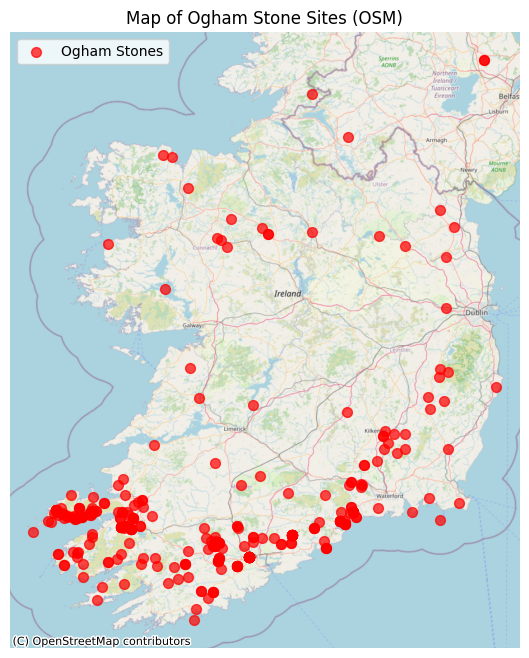

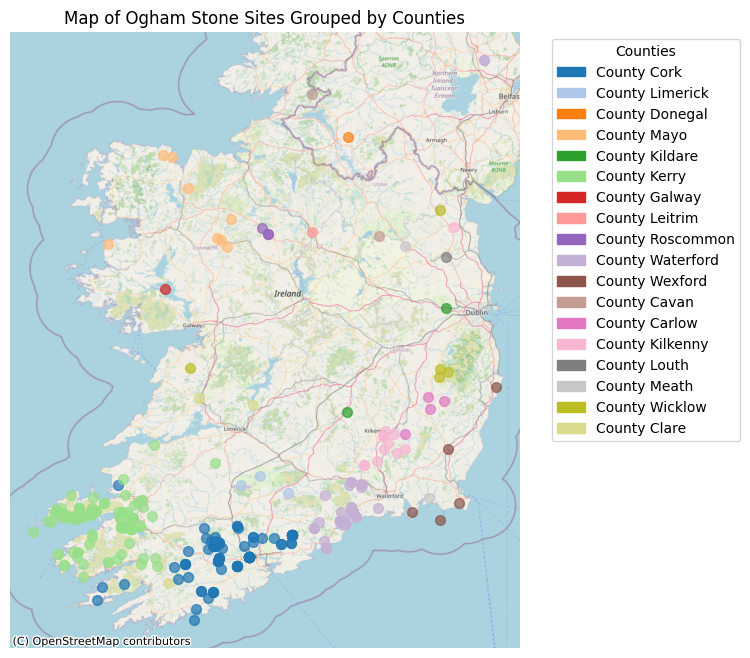

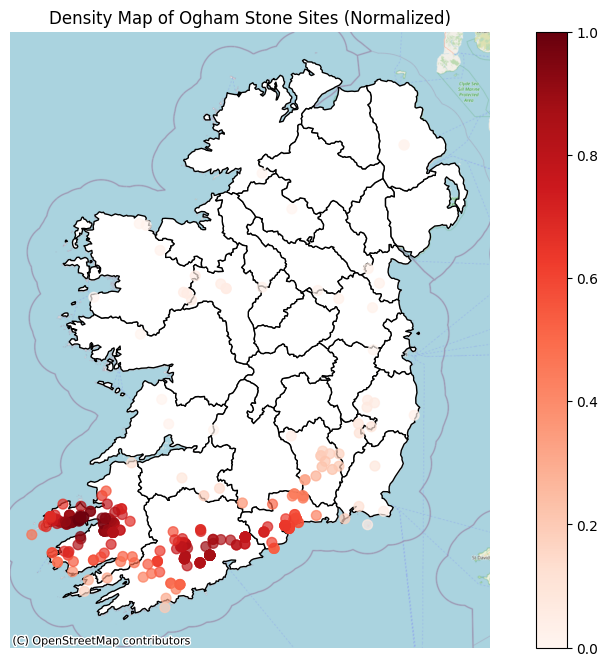

In [9]:
# Check if DataFrame is populated
if df.empty:
    print("No data retrieved from the query.")
else:
    # Filter rows with valid coordinates
    df_with_coords = df.dropna(subset=['latitude', 'longitude'])

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df_with_coords,
        geometry=[Point(xy) for xy in zip(df_with_coords['longitude'], df_with_coords['latitude'])],
        crs="EPSG:4326"
    )

    # Convert to Web Mercator for OSM basemap
    gdf_mercator = gdf.to_crs(epsg=3857)

    # Load Ireland boundary from GeoJSON
    ireland_boundary = gpd.read_file(geojson_file)
    ireland_boundary = ireland_boundary.to_crs(epsg=3857)

    # Map 1: Plot points without text decorations
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf_mercator.plot(ax=ax, color='red', markersize=50, alpha=0.7, label="Ogham Stones")
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=8)
    ax.set_axis_off()
    plt.title("Map of Ogham Stone Sites (OSM)")
    plt.legend()
    plt.show()

    # Map 2: Plot with points colored by county and fix legend
    fig, ax = plt.subplots(figsize=(12, 8))
    unique_counties = gdf['countyLabel'].unique()
    colors = plt.cm.tab20.colors[:len(unique_counties)]  # Generate unique colors
    county_colors = {county: colors[idx] for idx, county in enumerate(unique_counties)}

    patches = []
    for county, color in county_colors.items():
        county_data = gdf_mercator[gdf_mercator['countyLabel'] == county]
        county_data.plot(ax=ax, color=color, markersize=50, alpha=0.7)
        patches.append(Patch(color=color, label=county))  # Add patch for legend

    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=8)
    ax.set_axis_off()
    plt.title("Map of Ogham Stone Sites Grouped by Counties")
    plt.legend(handles=patches, title="Counties", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Map 3: Density map with normalized values
    x = gdf_mercator.geometry.x
    y = gdf_mercator.geometry.y

    # Calculate kernel density
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    density = kde(xy)

    # Normalize density to range [0, 1]
    density_normalized = (density - density.min()) / (density.max() - density.min())
    gdf_mercator['density'] = density_normalized

    fig, ax = plt.subplots(figsize=(12, 8))
    ireland_boundary.plot(ax=ax, color="white", edgecolor="black")
    gdf_mercator.plot(ax=ax, column='density', cmap="Reds", markersize=50, alpha=0.7, legend=True)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=8)
    ax.set_axis_off()
    plt.title("Density Map of Ogham Stone Sites (Normalized)")
    plt.show()
